In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import glob
import tqdm
import copy
from PIL import Image

In [2]:
def get_set_filenames(split_path:str):
    with open(split_path, "r") as f:
        return f.read().split("\n")

def load_label_json(filename):
    with open(filename, "r") as f:
        return json.load(f)

### Explore Dataset

In [3]:
labels_folder_path = "data\\mapillary\\annotations\\"
images_folder_path = "data\\mapillary\\images\\"
splits_folder_path = "data\\mapillary\\splits\\"

In [4]:
all_labels_paths = glob.glob(f"{labels_folder_path}*.json")
all_images_paths = glob.glob(f"{images_folder_path}*.jpg")

print("Number of found labels:", len(all_labels_paths))
print("Number of found images:", len(all_images_paths))

print()
if len(all_labels_paths) != len(all_images_paths):
    print("Synchronization needed!")
print()
    
train_names = get_set_filenames(f"{splits_folder_path}train.txt")
val_names = get_set_filenames(f"{splits_folder_path}val.txt")
test_names = get_set_filenames(f"{splits_folder_path}test.txt")

print("Number of train files:", len(train_names))
print("Number of val files:", len(val_names))
print("Number of test files:", len(test_names))

total_number_of_files = len(train_names) + len(val_names) + len(test_names)

print()
if total_number_of_files != len(all_images_paths):
    print("Synchronization needed!")
print() 

labels_names = set(map(lambda x: x.split("\\")[-1].replace(".json", ""), all_labels_paths))
images_names = set(map(lambda x: x.split("\\")[-1].replace(".jpg", ""), all_images_paths))
common_names = images_names & labels_names
print("Number of valid image/label pairs:", len(common_names))

available_train_names = set(train_names) & common_names
available_val_names = set(val_names) & common_names
available_test_names = set(test_names) & common_names
print("Number of valid train image/label pairs:", len(available_train_names))
print("Number of valid val image/label pairs:", len(available_val_names))
print("Number of valid test image/label pairs:", len(available_test_names))

Number of found labels: 41909
Number of found images: 52453

Synchronization needed!

Number of train files: 36589
Number of val files: 5320
Number of test files: 10544


Number of valid image/label pairs: 41909
Number of valid train image/label pairs: 36589
Number of valid val image/label pairs: 5320
Number of valid test image/label pairs: 0


## Setup Dataset

In [5]:
CATEGORY_FILTER = "warning"
VARIANT_SEPARATION = False
MIN_LABELS_TO_USE = 100
IMAGE_SIZE = (512, 512)

### Get all labels in dataset

In [6]:
import concurrent.futures
import json
import tqdm

def load_label_json(label_path):
    with open(label_path, 'r') as file:
        return json.load(file)

def process_label_file(label_path):
    local_label_count = {}
    label_dict = load_label_json(label_path)
    for obj in label_dict['objects']:
        if obj['label'] == 'other-sign':
            continue
        if obj['label'] in local_label_count:
            local_label_count[obj['label']]['count'] += 1
        else:
            local_label_count[obj['label']] = {'count': 1, 
                                               'category': obj['label'].split("--")[0], 
                                               'name': obj['label'].split("--")[1],
                                               'variant': obj['label'].split("--")[-1],
                                              } 
    return local_label_count

def merge_label_counts(all_counts):
    global_label_count = {}
    for local_count in all_counts:
        for label, label_info in local_count.items():
            if label in global_label_count:
                global_label_count[label]['count'] += label_info['count']
            else:
                global_label_count[label] = label_info
    return global_label_count

In [7]:
# Adjust the max_workers as needed, depending on your system's capabilities
with concurrent.futures.ThreadPoolExecutor(max_workers=500) as executor:
    # Map the label processing function over all label paths
    results = list(tqdm.tqdm(executor.map(process_label_file, all_labels_paths), total=len(all_labels_paths), position=0))

# Merge the results from all threads
all_labels = merge_label_counts(results)

# Create the label map
label_map = {lbl: i for i, lbl in enumerate(all_labels)}

100%|██████████████████████████████████████████████████████████████████████████████| 41909/41909 [00:00<00:00, 143524.53it/s]


In [8]:
all_labels_copy = copy.deepcopy(all_labels)
labels_to_use_stats = {}

for label_key in all_labels_copy:
    all_labels_copy[label_key]['use'] = True
    all_labels_copy[label_key]['index'] = None

    if CATEGORY_FILTER and (all_labels_copy[label_key]['category'] != CATEGORY_FILTER):
        all_labels_copy[label_key]['use'] = False

    all_labels_copy[label_key]['use_name'] = label_key if VARIANT_SEPARATION else label_key.split("--")[1]
    
    if not all_labels_copy[label_key]['use']:
        continue
        
    if all_labels_copy[label_key]['use_name'] in labels_to_use_stats:
        labels_to_use_stats[all_labels_copy[label_key]['use_name']] += all_labels_copy[label_key]['count']
    else:
        labels_to_use_stats[all_labels_copy[label_key]['use_name']] = all_labels_copy[label_key]['count']

label_to_index_mapping = {j:i for i, j in enumerate(labels_to_use_stats.keys())}

for label_key in all_labels_copy:
    if all_labels_copy[label_key]['use_name'] in label_to_index_mapping:
        all_labels_copy[label_key]['index'] = label_to_index_mapping[all_labels_copy[label_key]['use_name']]

print("Resulting number of classes:", len(labels_to_use_stats))

Resulting number of classes: 76


In [9]:
classes_str = ""

for lbl in label_to_index_mapping:
    classes_str += f"  {label_to_index_mapping[lbl]}: {lbl}\n"

training_yaml_file = \
f"""
path: mapillary/
train: 'images/train'
val: 'images/val'
 
# class names
names: 
{classes_str}
""".strip()

with open(f"mapillary_{CATEGORY_FILTER.lower().strip()}_traffic_signs.yaml", "w") as f:
    f.write(training_yaml_file)

print(training_yaml_file)

path: mapillary/
train: 'images/train'
val: 'images/val'
 
# class names
names: 
  0: railroad-crossing-with-barriers
  1: curve-left
  2: falling-rocks-or-debris-right
  3: pedestrians-crossing
  4: curve-right
  5: railroad-crossing
  6: crossroads
  7: railroad-crossing-without-barriers
  8: slippery-road-surface
  9: junction-with-a-side-road-acute-right
  10: height-restriction
  11: double-curve-first-left
  12: divided-highway-ends
  13: roundabout
  14: road-widens
  15: road-bump
  16: uneven-road
  17: junction-with-a-side-road-perpendicular-right
  18: double-curve-first-right
  19: road-narrows-left
  20: children
  21: y-roads
  22: trail-crossing
  23: texts
  24: road-narrows-right
  25: narrow-bridge
  26: other-danger
  27: junction-with-a-side-road-acute-left
  28: junction-with-a-side-road-perpendicular-left
  29: hairpin-curve-left
  30: winding-road-first-left
  31: turn-right
  32: traffic-signals
  33: added-lane-right
  34: emergency-vehicles
  35: winding-road-

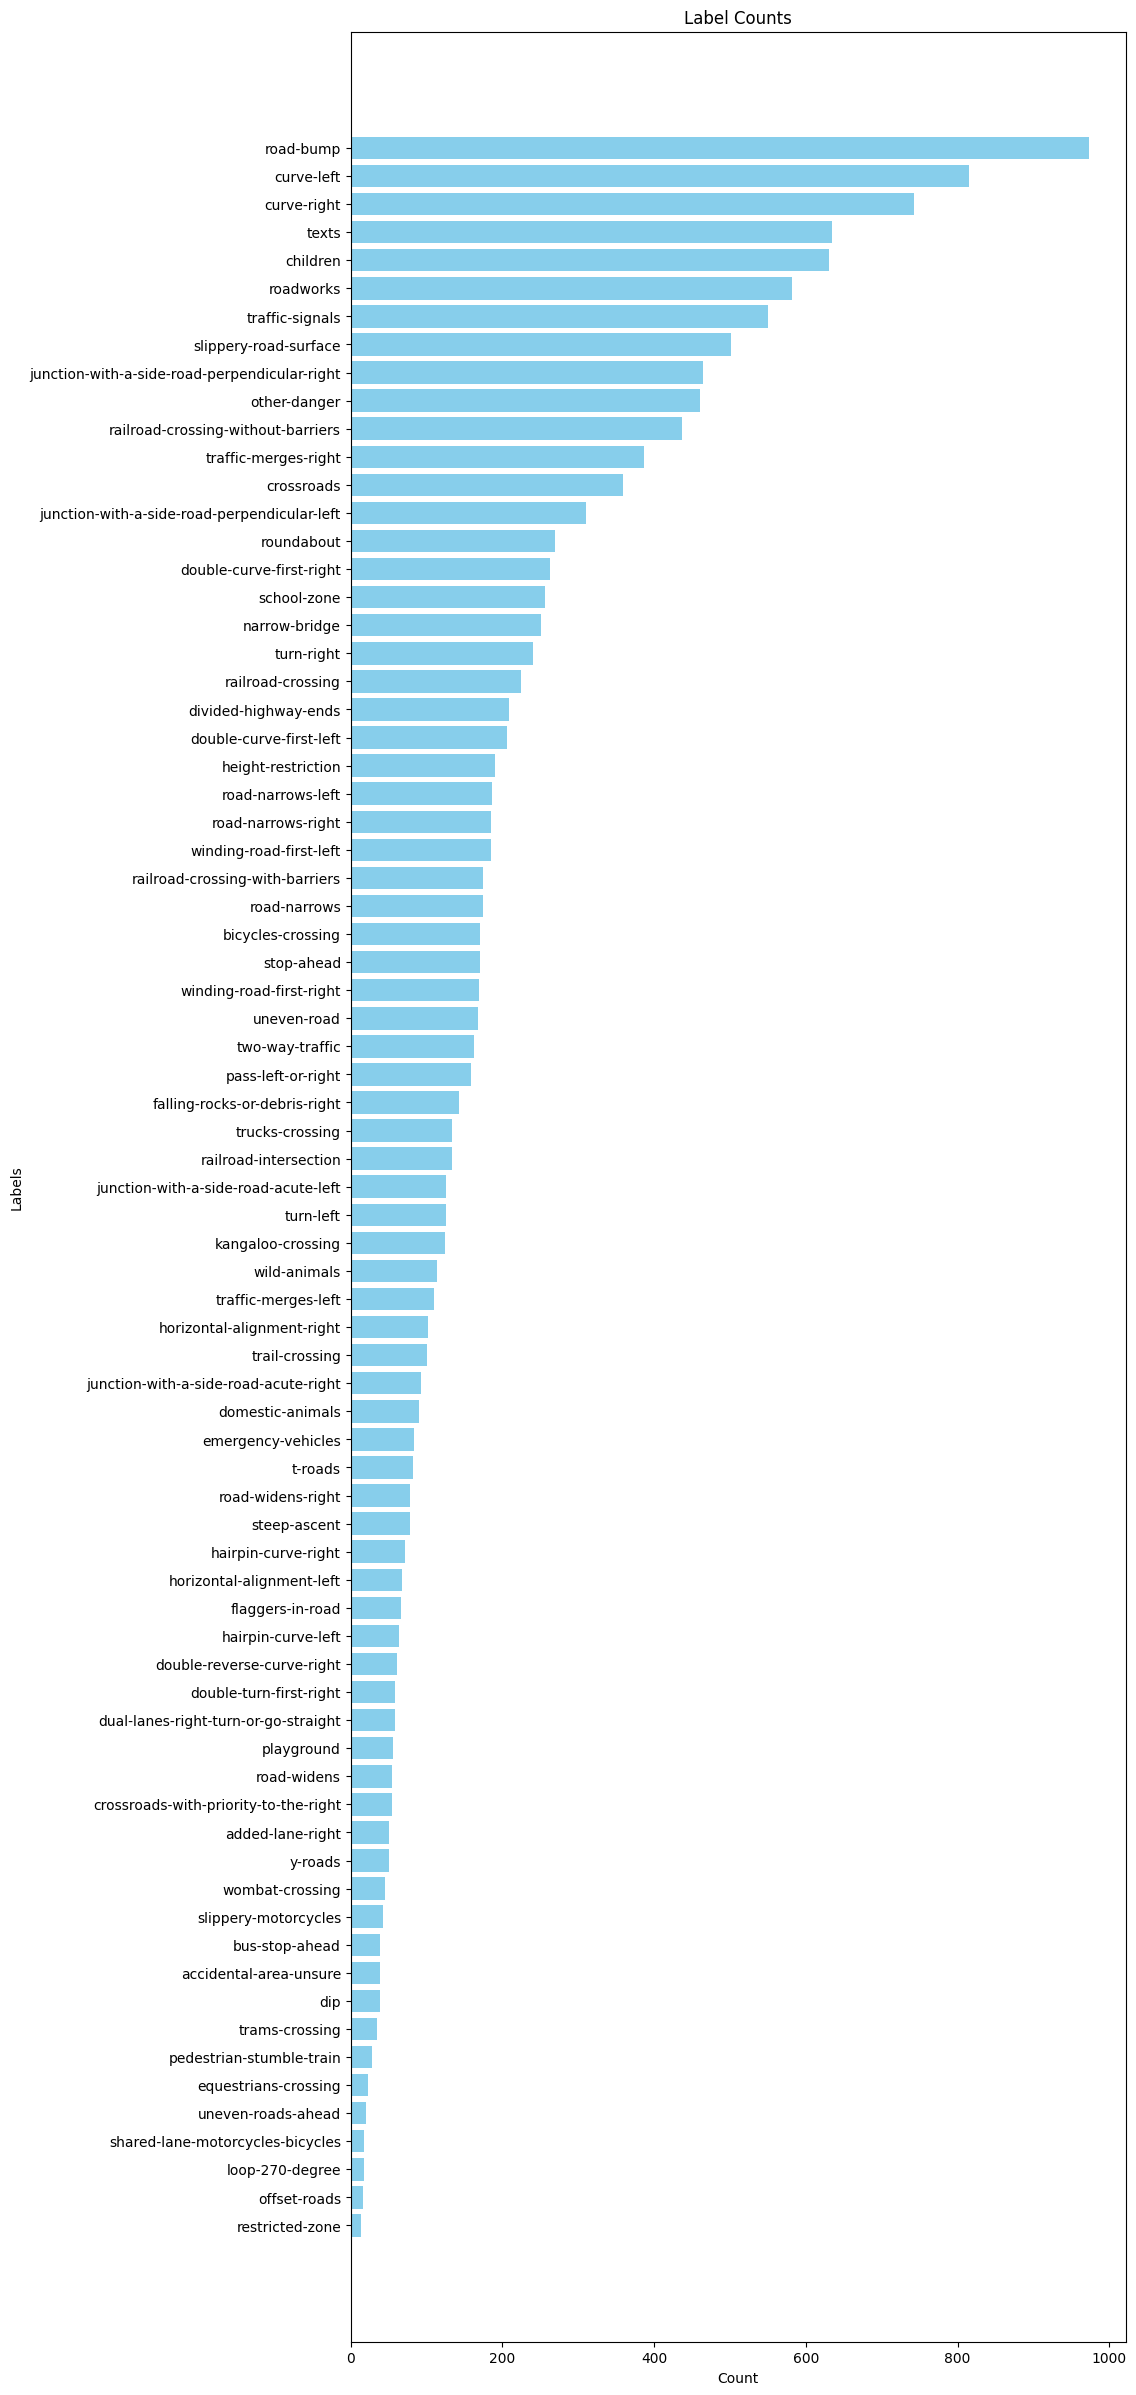

In [10]:
# Sort the labels by count in descending order
sorted_labels= sorted(labels_to_use_stats.items(), key=lambda x: x[1], reverse=True)

# Unpack the sorted items into two lists
labels, counts = zip(*sorted_labels[1:])

# Create the vertical bar plot
plt.figure(figsize=(10, 30))  # Adjust the figure size as needed
plt.barh(labels, counts, color='skyblue')  # Horizontal bar plot
plt.xlabel('Count')
plt.ylabel('Labels')
plt.title('Label Counts')
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest count at the top
plt.show()

### Populate `labels` folder

In [11]:
yolo_labels_folder_path = "datasets\\mapillary\\labels\\"

for label_path in tqdm.tqdm(all_labels_paths, position=0):
    filename = label_path.split("\\")[-1].replace(".json", "")

    set_suffix = None
    
    if filename in available_train_names:
        set_suffix = "train\\"

    if filename in available_val_names:
        set_suffix = "val\\"

    if set_suffix is None:
        print("Set of", label_path, "cannot be determined. Skipping...")
        continue
    
    label_dict = load_label_json(label_path)
    w, h = label_dict['width'], label_dict['height']
    label_txt = ""
    
    for obj in label_dict['objects']:
        label_full_name = obj['label']
        
        if (label_full_name != 'other-sign') and all_labels_copy[label_full_name]['use']:
            lbl_indx = all_labels_copy[label_full_name]['index']
        else:
            break
        
        x_center = np.mean([obj['bbox']['xmin'], obj['bbox']['xmax']]) / w
        y_center = np.mean([obj['bbox']['ymin'], obj['bbox']['ymax']]) / h
        x_length = (obj['bbox']['xmax'] - obj['bbox']['xmin']) / w
        y_length = (obj['bbox']['ymax'] - obj['bbox']['ymin']) / h
        label_txt += f"{lbl_indx} {x_center} {y_center} {x_length} {y_length}\n"

    label_txt = label_txt.strip()
    if label_txt:
        filename = yolo_labels_folder_path + set_suffix + label_path.split("\\")[-1].replace(".json", "") + ".txt"
    
        with open(filename, "w") as f:
            f.write(label_txt)

100%|████████████████████████████████████████████████████████████████████████████████| 41909/41909 [00:05<00:00, 7027.65it/s]


### Populate `images` folder

In [12]:
# import concurrent.futures
# import os

# yolo_images_folder_path = "datasets\\mapillary\\images\\"


# def process_and_save_image(image_path):
#     filename = image_path.split("\\")[-1].replace(".jpg", "")
#     set_suffix = None

#     if filename in available_train_names:
#         set_suffix = "train\\"
#     elif filename in available_val_names:
#         set_suffix = "val\\"
    
#     if set_suffix is None:
#         return

#     # Adjusted to use os.path.join for better path handling
#     filename = os.path.join(yolo_images_folder_path, set_suffix, filename + ".png").strip()

#     # image = Image.open(image_path).resize(IMAGE_SIZE)
#     image = Image.open(image_path)
#     image.save(filename)
#     image.close()

# # Adjust the max_workers as needed
# with concurrent.futures.ThreadPoolExecutor(max_workers=200) as executor:
#     # List to store futures
#     future_to_image = {executor.submit(process_and_save_image, image_path): image_path for image_path in all_images_paths}
    
#     # Process futures as they complete
#     for future in tqdm.tqdm(concurrent.futures.as_completed(future_to_image), total=len(future_to_image), position=0):
#         image_path = future_to_image[future]
#         try:
#             data = future.result()
#         except Exception as exc:
#             print('%r generated an exception: %s' % (image_path, exc))

## Training

In [13]:
from ultralytics import YOLO
 
# Load the model.
model = YOLO('yolov8l.pt')

In [ ]:
# Training.
results = model.train(
   data='mapillary_warning_traffic_signs.yaml',
   imgsz=512,
   epochs=150,
   batch=16,
   mosaic=0.0,
   name='yolov8l_mapillary_warning_traffic_signs',
)

New https://pypi.org/project/ultralytics/8.1.25 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.186  Python-3.11.8 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12287MiB)
engine\trainer: task=detect, mode=train, model=yolov8l.pt, data=mapillary_warning_traffic_signs.yaml, epochs=150, patience=50, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8l_mapillary_warning_traffic_signs, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=Fals

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed 
train: Scanning E:\traffic-sign-detection\datasets\mapillary\labels\train... 7462 images, 30371 backgrounds, 169 corrupt: 100
train: WARNING  E:\traffic-sign-detection\datasets\mapillary\images\train\0H3AeIq28VJbc4hrcp6u5g.png: ignoring corrupt image/label: broken PNG file (incomplete checksum in b'IDAT')
train: WARNING  E:\traffic-sign-detection\datasets\mapillary\images\train\0Iea6-Uwg84geO5E0U3nxQ.png: ignoring corrupt image/label: broken PNG file (incomplete checksum in b'IDAT')
train: WARNING  E:\traffic-sign-detection\datasets\mapillary\images\train\0JHTIs4IAEXyXU16n253aQ.png: ignoring corrupt image/label: broken PNG file (incomplete checksum in b'IDAT')
train: WARNING  E:\traffic-sign-detection\datasets\mapillary\images\train\0NEjIVxUWVXJCnc8OLlTOQ.png: ignoring corrupt image/label: broken PNG file (incomplete checksum in b'IDAT')
train: WARNING  E:\t